# Period 4 -  Analyses of ChIP Seq data


# Abstract

ChIP-seq is a protocol for inferring the locations of proteins bound or associated with DNA. The raw data looks quite different than DNA- or RNA-seq, in that the NGS reads form tall "peaks" at the locations where the proteins were tightly bound to DNA in the cells which were used to create the sample. More specifically, ChIP-seq results in two peaks of reads of different strands (plus/minus also referred to as Watson/Crick), as shown in [Figure 1](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2592715/figure/F1/) of the MACS manuscript: [Zhang 2008](#foot).

Most materials come from the [PH525x](https://github.com/genomicsclass/labs/blob/master/chipseq/ChIPseq.Rmd) lab.

#  Approaches to peak calling and merging

## Peak calling

In the first lab, we use the MACS software to call peaks. The code for this is in the [MACS.txt](https://github.com/genomicsclass/labs/blob/master/course7/MACS.txt) file.

There are many different algorithms for calling peaks, which have varying performance on different kinds of experiments. As mentioned in the lecture, for ChIP of proteins with broad peaks (such as modified histones), algorithms other than those for detecting sharp peaks might perform better.

## After peak calling

A number of analyses might be of interest following peak calling. In this lab we will focus on differential binding across samples, by focusing on the peak regions and counting the number of ChIP-seq reads which fall into the peaks for each sample.

Motif-finding is common ChIP-seq analysis which is not explored in this course, as we do not cover the basics of analysis of sequences. Motif-finding refers to the task of looking for common strings of DNA letters contained within peaks. These are biologically meaningful, as a number of proteins which are bound to DNA have conformations which make certain strings of DNA letters more preferable for binding. For more references, see the [Footnotes](#foot).

#  Calling differential binding across samples

The following lab will go over the functionality of the `DiffBind` package, mostly using code from the vignette. This package is useful for manipulating ChIP-seq signal in R, for comparing signal across files and for performing tests of differential binding.

## Reading peak files into R

The `DiffBind` package provides some called peaks that we can analyze. From the `DiffBind` vignette:

> The dataset for this example consists of ChIPs against the transcription factor ERa using five breast cancer cell lines (C.S. Ross-Innes et al, Nature 481(7381):389–393, 2012). Three of these cell lines are responsive to tamoxifen treatment, while two others are resistant to tamoxifen. There are at least two replicates for each of the cell lines, with one cell line having three replicates, for a total of eleven sequenced libraries.

> Of the five cell lines, two are based on MCF7 cells: the regular tamoxifen responsive line,
as well as MCF7 cells specially treated with tamoxifen until a tamoxifen resistant cell line
is obtained. For each sample, we have one peakset originally derived using the MACS peak
caller (Y. Zhang et al, Genome Biol, 9(9):R137, 2008), for a total of eleven peaksets. Note that to save space in the package, only data for chromosome 18 is used for the vignette.

We're going to take this opportunity to demonstrate the use of BiocFileCache to organize and keep track of files:

In [19]:
suppressPackageStartupMessages({
    library(DiffBind)
    library(BiocFileCache)
})
bfc <- BiocFileCache(cache="~/chipseq-data")
DBfiles <- list.files(system.file("extra", package="DiffBind"), 
                     recursive = TRUE, full.names = TRUE)
DBfiles <- DBfiles[!DBfiles %in% bfcinfo(bfc)$rname]
for (i in seq_along(DBfiles))
  bfcadd(bfc, rname=DBfiles[i], rtype="local", action="copy")

Peaks are represented as a `.bed` file per sample, in this example summarized in `tamoxifen.csv`:

In [2]:
tamfile <- bfcquery(bfc, "tamoxifen.csv")$fpath
read.csv(tamfile)

SampleID,Tissue,Factor,Condition,Treatment,Replicate,bamReads,ControlID,bamControl,Peaks,PeakCaller
BT4741,BT474,ER,Resistant,Full-Media,1,reads/Chr18_BT474_ER_1.bam,BT474c,reads/Chr18_BT474_input.bam,peaks/BT474_ER_1.bed.gz,bed
BT4742,BT474,ER,Resistant,Full-Media,2,reads/Chr18_BT474_ER_2.bam,BT474c,reads/Chr18_BT474_input.bam,peaks/BT474_ER_2.bed.gz,bed
MCF71,MCF7,ER,Responsive,Full-Media,1,reads/Chr18_MCF7_ER_1.bam,MCF7c,reads/Chr18_MCF7_input.bam,peaks/MCF7_ER_1.bed.gz,bed
MCF72,MCF7,ER,Responsive,Full-Media,2,reads/Chr18_MCF7_ER_2.bam,MCF7c,reads/Chr18_MCF7_input.bam,peaks/MCF7_ER_2.bed.gz,bed
MCF73,MCF7,ER,Responsive,Full-Media,3,reads/Chr18_MCF7_ER_3.bam,MCF7c,reads/Chr18_MCF7_input.bam,peaks/MCF7_ER_3.bed.gz,bed
T47D1,T47D,ER,Responsive,Full-Media,1,reads/Chr18_T47D_ER_1.bam,T47Dc,reads/Chr18_T47D_input.bam,peaks/T47D_ER_1.bed.gz,bed
T47D2,T47D,ER,Responsive,Full-Media,2,reads/Chr18_T47D_ER_2.bam,T47Dc,reads/Chr18_T47D_input.bam,peaks/T47D_ER_2.bed.gz,bed
MCF7r1,MCF7,ER,Resistant,Full-Media,1,reads/Chr18_TAMR_ER_1.bam,TAMRc,reads/Chr18_TAMR_input.bam,peaks/TAMR_ER_1.bed.gz,bed
MCF7r2,MCF7,ER,Resistant,Full-Media,2,reads/Chr18_TAMR_ER_2.bam,TAMRc,reads/Chr18_TAMR_input.bam,peaks/TAMR_ER_2.bed.gz,bed
ZR751,ZR75,ER,Responsive,Full-Media,1,reads/Chr18_ZR75_ER_1.bam,ZR75c,reads/Chr18_ZR75_input.bam,peaks/ZR75_ER_1.bed.gz,bed


Just as a note, we now have the paths of all these files stored in our `BiocFileCache`:

In [3]:
bfcquery(bfc, "peaks")$rpath

[1] "/Library/Frameworks/R.framework/Versions/3.4/Resources/library/DiffBind/extra/peaks/BT474_ER_1.bed.gz"
 [2] "/Library/Frameworks/R.framework/Versions/3.4/Resources/library/DiffBind/extra/peaks/BT474_ER_2.bed.gz"
 [3] "/Library/Frameworks/R.framework/Versions/3.4/Resources/library/DiffBind/extra/peaks/MCF7_ER_1.bed.gz" 
 [4] "/Library/Frameworks/R.framework/Versions/3.4/Resources/library/DiffBind/extra/peaks/MCF7_ER_2.bed.gz" 
 [5] "/Library/Frameworks/R.framework/Versions/3.4/Resources/library/DiffBind/extra/peaks/MCF7_ER_3.bed.gz" 
 [6] "/Library/Frameworks/R.framework/Versions/3.4/Resources/library/DiffBind/extra/peaks/T47D_ER_1.bed.gz" 
 [7] "/Library/Frameworks/R.framework/Versions/3.4/Resources/library/DiffBind/extra/peaks/T47D_ER_2.bed.gz" 
 [8] "/Library/Frameworks/R.framework/Versions/3.4/Resources/library/DiffBind/extra/peaks/TAMR_ER_1.bed.gz" 
 [9] "/Library/Frameworks/R.framework/Versions/3.4/Resources/library/DiffBind/extra/peaks/TAMR_ER_2.bed.gz" 
[10] "/Library/Frameworks/R.framework/Versions/3.4/Resources/library/DiffBind/extra/peaks/ZR75_ER_1.bed.gz" 
[11] "/Library/Frameworks/R.framework/Versions/3.4/Resources/library/DiffBind/extra/peaks/ZR75_ER_2.bed.gz"

## Peak merging and differential binding setup

The `dba` function creates the basic object for an analysis of *Differential Binding Affinity*. The sample sheet specifies a data frame of file with certain required columns. Note that columns have restricted names, including *Tissue*, *Factor*, *Condition*, etc., which will be referred to later in analysis.

This function will automatically create a correlation plot showing the overlap of the peaks for all the samples.

In [4]:
setwd(system.file("extra", package="DiffBind")) #necessary because `tamfile` contains relative paths
ta <- dba(sampleSheet=tamfile)
ta

BT4741 BT474 ER Resistant Full-Media 1 bed
BT4742 BT474 ER Resistant Full-Media 2 bed
MCF71 MCF7 ER Responsive Full-Media 1 bed
MCF72 MCF7 ER Responsive Full-Media 2 bed
MCF73 MCF7 ER Responsive Full-Media 3 bed
T47D1 T47D ER Responsive Full-Media 1 bed
T47D2 T47D ER Responsive Full-Media 2 bed
MCF7r1 MCF7 ER Resistant Full-Media 1 bed
MCF7r2 MCF7 ER Resistant Full-Media 2 bed
ZR751 ZR75 ER Responsive Full-Media 1 bed
ZR752 ZR75 ER Responsive Full-Media 2 bed


11 Samples, 2845 sites in matrix (3795 total):
       ID Tissue Factor  Condition  Treatment Replicate Caller Intervals
1  BT4741  BT474     ER  Resistant Full-Media         1    bed      1080
2  BT4742  BT474     ER  Resistant Full-Media         2    bed      1122
3   MCF71   MCF7     ER Responsive Full-Media         1    bed      1556
4   MCF72   MCF7     ER Responsive Full-Media         2    bed      1046
5   MCF73   MCF7     ER Responsive Full-Media         3    bed      1339
6   T47D1   T47D     ER Responsive Full-Media         1    bed       527
7   T47D2   T47D     ER Responsive Full-Media         2    bed       373
8  MCF7r1   MCF7     ER  Resistant Full-Media         1    bed      1438
9  MCF7r2   MCF7     ER  Resistant Full-Media         2    bed       930
10  ZR751   ZR75     ER Responsive Full-Media         1    bed      2346
11  ZR752   ZR75     ER Responsive Full-Media         2    bed      2345

From the `DiffBind` vignette, we have:

> This shows how many peaks are in each peakset, as well as (in the first line) the total number of unique peaks after merging overlapping ones (3795), and the dimensions of dba.plotPCA (default binding matrix of 11 samples by the 2845 sites that overlap in at least two of the samples). 

We can access the peaks for each file:

In [5]:
names(ta)
class(ta$peaks)
head(ta$peaks[[1]])

[1] "config"      "chrmap"      "peaks"       "class"       "masks"      
 [6] "samples"     "called"      "totalMerged" "merged"      "binding"    
[11] "attributes"  "minOverlap"

[1] "list"

V1,V2,V3,V5
chr18,215562,216063,0.01742633
chr18,311530,312105,0.06909971
chr18,356656,357315,0.02859148
chr18,371110,372092,0.03846775
chr18,395116,396464,0.47995863
chr18,399014,400382,0.56996310


## Differential binding

The following code chunk will count the reads from the BAM files specified in the `samples` slot:

In [6]:
ta$samples

SampleID,Tissue,Factor,Condition,Treatment,Replicate,bamReads,ControlID,bamControl,Peaks,PeakCaller
BT4741,BT474,ER,Resistant,Full-Media,1,reads/Chr18_BT474_ER_1.bam,BT474c,reads/Chr18_BT474_input.bam,peaks/BT474_ER_1.bed.gz,bed
BT4742,BT474,ER,Resistant,Full-Media,2,reads/Chr18_BT474_ER_2.bam,BT474c,reads/Chr18_BT474_input.bam,peaks/BT474_ER_2.bed.gz,bed
MCF71,MCF7,ER,Responsive,Full-Media,1,reads/Chr18_MCF7_ER_1.bam,MCF7c,reads/Chr18_MCF7_input.bam,peaks/MCF7_ER_1.bed.gz,bed
MCF72,MCF7,ER,Responsive,Full-Media,2,reads/Chr18_MCF7_ER_2.bam,MCF7c,reads/Chr18_MCF7_input.bam,peaks/MCF7_ER_2.bed.gz,bed
MCF73,MCF7,ER,Responsive,Full-Media,3,reads/Chr18_MCF7_ER_3.bam,MCF7c,reads/Chr18_MCF7_input.bam,peaks/MCF7_ER_3.bed.gz,bed
T47D1,T47D,ER,Responsive,Full-Media,1,reads/Chr18_T47D_ER_1.bam,T47Dc,reads/Chr18_T47D_input.bam,peaks/T47D_ER_1.bed.gz,bed
T47D2,T47D,ER,Responsive,Full-Media,2,reads/Chr18_T47D_ER_2.bam,T47Dc,reads/Chr18_T47D_input.bam,peaks/T47D_ER_2.bed.gz,bed
MCF7r1,MCF7,ER,Resistant,Full-Media,1,reads/Chr18_TAMR_ER_1.bam,TAMRc,reads/Chr18_TAMR_input.bam,peaks/TAMR_ER_1.bed.gz,bed
MCF7r2,MCF7,ER,Resistant,Full-Media,2,reads/Chr18_TAMR_ER_2.bam,TAMRc,reads/Chr18_TAMR_input.bam,peaks/TAMR_ER_2.bed.gz,bed
ZR751,ZR75,ER,Responsive,Full-Media,1,reads/Chr18_ZR75_ER_1.bam,ZR75c,reads/Chr18_ZR75_input.bam,peaks/ZR75_ER_1.bed.gz,bed


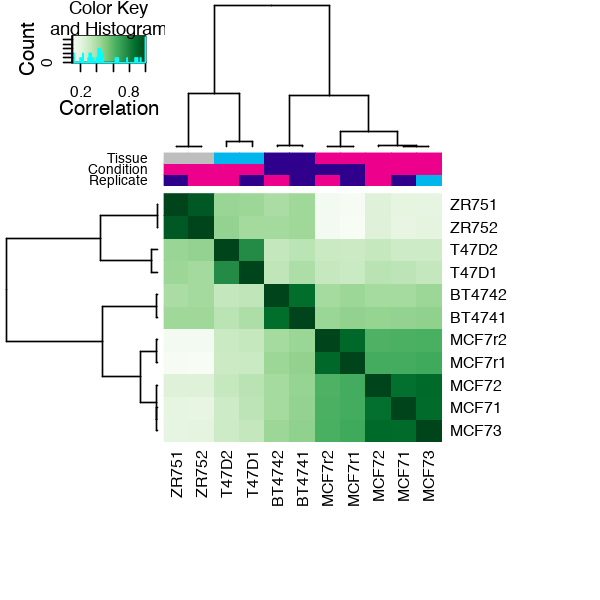

In [7]:
options(repr.plot.width=5, repr.plot.height=5)
# the next line does not actually work, because the BAM files are not included in the package
# ta <- dba.count(ta, minOverlap=3)
# instead we load the counts:
data(tamoxifen_counts)
plot(tamoxifen)

We can perform a test by specifying to contrast over the levels of condition. This will call DESeq software in order to normalize samples for sequencing depth and perform essentially the same analysis as a differential expression analysis for RNA-Seq counts:

In [8]:
tamoxifen$config$AnalysisMethod

[1] DESeq2
Levels: DESeq2

The plot produced then looks at correlation only for those peaks which showed evidence of differential binding.

In [9]:
ta2 <- dba.contrast(tamoxifen, categories=DBA_CONDITION)
ta2 <- dba.analyze(ta2)
ta2

converting counts to integer mode
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


11 Samples, 2845 sites in matrix:
       ID Tissue Factor  Condition  Treatment Replicate Caller Intervals FRiP
1  BT4741  BT474     ER  Resistant Full-Media         1 counts      2845 0.16
2  BT4742  BT474     ER  Resistant Full-Media         2 counts      2845 0.15
3   MCF71   MCF7     ER Responsive Full-Media         1 counts      2845 0.27
4   MCF72   MCF7     ER Responsive Full-Media         2 counts      2845 0.17
5   MCF73   MCF7     ER Responsive Full-Media         3 counts      2845 0.23
6   T47D1   T47D     ER Responsive Full-Media         1 counts      2845 0.10
7   T47D2   T47D     ER Responsive Full-Media         2 counts      2845 0.06
8  MCF7r1   MCF7     ER  Resistant Full-Media         1 counts      2845 0.20
9  MCF7r2   MCF7     ER  Resistant Full-Media         2 counts      2845 0.13
10  ZR751   ZR75     ER Responsive Full-Media         1 counts      2845 0.32
11  ZR752   ZR75     ER Responsive Full-Media         2 counts      2845 0.22

1 Contrast:
     Group1 Membe

*Note*: We could have included the tissue as a blocking factor, by providing `DBA_TISSUE` to the `block` argument of `dba.contrast`.

From the `DiffBind` vignette, we have:

> By default, dba.analyze plots a correlation heatmap if it finds any 
> significantly differentially bound sites, shown in Figure 3. Using only 
> the differentially bound sites, we now see that the four tamoxifen 
> resistant samples (representing two cell lines) cluster together, 
> although the tamoxifen-responsive MCF7 replicates cluster closer to them 
> than to the other tamoxifen responsive samples."

Finally, we can generate the results table, which is attached as metadata columns to the peaks as genomic ranges. By specifying `bCounts = TRUE`, we also obtain the normalized counts for each sample.

In [10]:
tadb <- dba.report(ta2)
tadb
counts <- dba.report(ta2, bCounts=TRUE)

GRanges object with 629 ranges and 6 metadata columns:
       seqnames               ranges strand |      Conc Conc_Resistant
          <Rle>            <IRanges>  <Rle> | <numeric>      <numeric>
  2452    chr18 [64490686, 64491186]      * |      6.36           1.39
  1291    chr18 [34597713, 34598213]      * |      5.33           0.22
   976    chr18 [26860997, 26861497]      * |       7.3           3.13
  2338    chr18 [60892900, 60893400]      * |      7.13           1.84
  2077    chr18 [55569087, 55569587]      * |      5.52           1.89
   ...      ...                  ...    ... .       ...            ...
   551    chr18 [14465945, 14466445]      * |      6.02           4.38
  2659    chr18 [71909888, 71910388]      * |      5.58           3.73
  2541    chr18 [68007206, 68007706]      * |      3.61           2.41
  1967    chr18 [52609747, 52610247]      * |      3.87           2.39
  2383    chr18 [61927095, 61927595]      * |      1.72          -0.22
       Conc_Responsive

##  Annotating and plotting peaks


First, do any differentially bound peaks overlap with genes? Yes, 299 of the 629 peaks do:

In [11]:
library(Homo.sapiens)
gn <- genes(Homo.sapiens, columns="SYMBOL")
summary(counts %over% gn)

Loading required package: AnnotationDbi
Loading required package: OrganismDbi
Loading required package: GenomicFeatures
Loading required package: GO.db
Loading required package: org.Hs.eg.db

Loading required package: TxDb.Hsapiens.UCSC.hg19.knownGene
'select()' returned 1:1 mapping between keys and columns


   Mode   FALSE    TRUE 
logical     330     299 

How many genes does each peak overlap with?

In [12]:
table(countOverlaps(counts, gn))


  0   1   2 
330 289  10 

Let's look at those peaks that overlap with two genes:

In [13]:
count2 <- counts[countOverlaps(counts, gn) == 2]
gn2 <- gn[gn %over% count2]
width(gn2) / 1e3  #width in kb
gn2 <- gn2[order(ranges(gn2))]
gn2

[1] 107.743 325.387  18.890  69.018 319.503  46.973 156.669 269.708 959.237

GRanges object with 9 ranges and 1 metadata column:
            seqnames               ranges strand |          SYMBOL
               <Rle>            <IRanges>  <Rle> | <CharacterList>
       9229    chr18 [ 3496030,  4455266]      - |          DLGAP1
     201477    chr18 [ 3878180,  3897069]      + |      DLGAP1-AS3
     147429    chr18 [24445272, 24770658]      + |        AQP4-AS1
      83539    chr18 [24495595, 24765302]      - |           CHST9
  100505549    chr18 [55297534, 55405276]      + |    LOC100505549
       5205    chr18 [55313659, 55470327]      - |          ATP8B1
     221241    chr18 [61747243, 61816260]      - |       LINC00305
     284294    chr18 [61771325, 62090827]      + |       LINC01924
     400654    chr18 [61880318, 61927290]      - |       LINC01538
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

## Plot peaks in the UCSC genome browser
Although the `DiffBind` package doesn't specify the genome, let's assume it is `hg19`, add a track to the `hg19` genome in the UCSC genome browser, then start the browser centered on the peak with greatest fold-change:

In [14]:
genome(counts) <- "hg19"
library(rtracklayer)
session <- browserSession("UCSC")
genome(session) <- "hg19"
track(session, "counts") <- counts

In [15]:
rangemaxFC <- counts[which.max(abs(counts$Fold))]
browserView(session, range=rangemaxFC * 0.75)  #0.75 zoom-factor

UCSCView of :33031597-33041570 
trackNames(10): 'counts' 'Base Position' ... 'Common SNPs(150)' 'RepeatMasker'

Finally, let's plot the peak that overlapped with *AQP4-AS1* on the sense strand and *CHST9* on the antisense strand:

In [16]:
gn2[3:4]

GRanges object with 2 ranges and 1 metadata column:
         seqnames               ranges strand |          SYMBOL
            <Rle>            <IRanges>  <Rle> | <CharacterList>
  147429    chr18 [24445272, 24770658]      + |        AQP4-AS1
   83539    chr18 [24495595, 24765302]      - |           CHST9
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

In [17]:
(plotrange <- reduce(gn2[3:4], ignore.strand=TRUE))

GRanges object with 1 range and 0 metadata columns:
      seqnames               ranges strand
         <Rle>            <IRanges>  <Rle>
  [1]    chr18 [24445272, 24770658]      *
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

In [18]:
browserView(session, range=plotrange * 0.75)

UCSCView of :69433024-69433691 
trackNames(10): 'counts' 'Base Position' ... 'Common SNPs(150)' 'RepeatMasker'

## Annotating peaks

The *ChIPseeker* library makes it easy to annotate peaks by overlapping genes, UTRs, promoters, ...

In [79]:
library(ChIPseeker)
peakAnno <-  annotatePeak(counts,
           TxDb = TxDb.Hsapiens.UCSC.hg19.knownGene)
peakAnno

>> preparing features information...		 2018-02-16 19:16:36 
>> identifying nearest features...		 2018-02-16 19:16:36 
>> calculating distance from peak to TSS...	 2018-02-16 19:16:36 
>> assigning genomic annotation...		 2018-02-16 19:16:36 
>> assigning chromosome lengths			 2018-02-16 19:16:39 
>> done...					 2018-02-16 19:16:39 


Annotated peaks generated by ChIPseeker
629/629  peaks were annotated
Genomic Annotation Summary:
              Feature  Frequency
8    Promoter (<=1kb)  3.9745628
9    Promoter (1-2kb)  1.4308426
10   Promoter (2-3kb)  2.3847377
3              5' UTR  0.3179650
2              3' UTR  0.4769475
6          Other Exon  2.0667727
1          1st Intron 10.8108108
7        Other Intron 27.9809221
5  Downstream (<=3kb)  0.1589825
4   Distal Intergenic 50.3974563

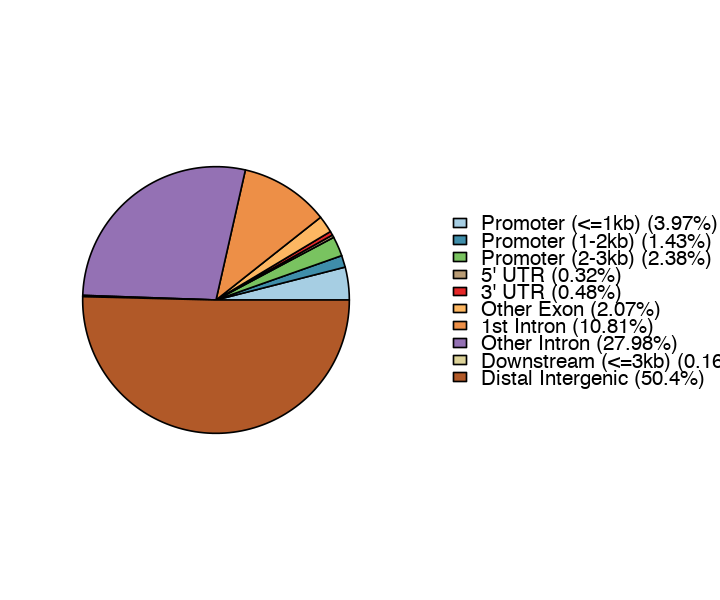

In [81]:
options(repr.plot.width=6, repr.plot.height=5)
plotAnnoPie(peakAnno)

**Exercise**: Look at the ChIPseeker vignette and perform additional visualizations of the peak annotations

## Blacklisted regions
Certain genomic regions are known to produce artefactual ChIP-seq peaks, and are most safely removed or ignored if a decent blacklist is available. For human, a good blacklist is available from ENCODE as a .bed file.

**Exercise**: Import the ENCODE blacklist file using *rtracklayer*. Do any of the peaks in our `counts` object overlap with blacklisted regions? The file import code is provided below.

In [57]:
suppressPackageStartupMessages(library(rtracklayer))
bl <- import("https://www.encodeproject.org/files/ENCFF419RSJ/@@download/ENCFF419RSJ.bed.gz", genome="hg19")

## Footnotes <a name="foot"></a>

### Model-based Analysis for ChIP-Seq (MACS)

Zhang Y, Liu T, Meyer CA, Eeckhoute J, Johnson DS, Bernstein BE, Nusbaum C, Myers RM, Brown M, Li W, Liu XS. "Model-based Analysis of ChIP-Seq (MACS)". Genome Biol. 2008.
<http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2592715/>

Software: 

<http://liulab.dfci.harvard.edu/MACS/>

### Motif finding

Wikipedia's article on DNA sequence motifs: <http://en.wikipedia.org/wiki/Sequence_motif>

A non-comprehensive list of software for motif finding:

- [MEME/DREME](http://meme.nbcr.net/meme/)
- [RSAT peak-motifs](http://rsat.ulb.ac.be/peak-motifs_form.cgi)
- [motifRG (Bioconductor)](http://www.bioconductor.org/packages/release/bioc/html/motifRG.html)
- [rGADEM (Bioconductor)](http://www.bioconductor.org/packages/release/bioc/html/rGADEM.html)

A survey of motif finding algorithms: <http://www.biomedcentral.com/1471-2105/8/S7/S21/>

### GenomicRanges cheat-sheet
![GenomicRanges cheat-sheet](https://github.com/waldronlab/BrownCOBRE2018/raw/master/notebooks_day2/GenomicRangesCheatSheet.png)